In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 400)

# ======================
# DATA CLEANING
# ======================

# FISH DETAILS

In [2]:
dtypes = {
    'YEAR': 'Int32', 
    'MM': 'Int32', 
    'DD': 'Int32', 
    'WEEK': 'Int32', 
    'SITE': 'object', 
    'PERIOD': 'object', 
    'CONDITION': 'object', 
    'FISH_NO': 'Int32', 
    'FL_WET.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_FROZEN.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_STD.x': 'float64',
    'WEIGHT': 'float64',
    'SPECIES': 'object', 
    'SEX': 'object', 
    'MATURITY.x': 'object',  # two entries that at 3?, (also 1 that is 44), convert to numeric, coerce errors
    'GONAD_WEIGHT': 'object',  # some '.' / 'NA', convert to numeric, coerce error to make 'NA' actually null
    'Ager.1': 'object',
    'AGE.1': 'object',  # convert to numeric and separate text comments
    'FSP.1': 'object',  # convert to numeric and separate text comments
    'Comments.1': 'object', 
    'Ager.2': 'object',  
    'AGE.2': 'object',  # convert to numeric and separate text comments
    'FSP.2': 'object',  # convert to numeric and separate text comments
    'Comments.2': 'object', 
    'Ager.3': 'object', 
    'AGE.3': 'object',  # convert to numeric and separate text comments
    'FSP.3': 'object',  # convert to numeric and separate text comments
    'Comments.3': 'object', 
    'Envelop Comments': 'object'
} 

df_FD = pd.read_excel('Gaspereau Ages_Combined.xlsx', dtype=dtypes)

# create backup of notes (including all numeric data for simplicity)
df_FD['AGE_notes_1'] = df_FD['AGE.1']
df_FD['FSP_notes_1'] = df_FD['FSP.1']
df_FD['AGE_notes_2'] = df_FD['AGE.2']
df_FD['FSP_notes_2'] = df_FD['FSP.2']
df_FD['AGE_notes_3'] = df_FD['AGE.3']
df_FD['FSP_notes_3'] = df_FD['FSP.3']

# convert to numeric and coerce errors
# for FL_WET.x, one measurement is a float (258.8), all else are int, need to round to convert to int
df_FD['FL_WET.x'] = np.round(pd.to_numeric(df_FD['FL_WET.x'], errors='coerce')).astype('Int32')
df_FD['FL_FROZEN.x'] = pd.to_numeric(df_FD['FL_FROZEN.x'], errors='coerce').astype('Int32')
df_FD['MATURITY.x'] = pd.to_numeric(df_FD['MATURITY.x'], errors='coerce').astype('Int32')
df_FD['GONAD_WEIGHT'] = pd.to_numeric(df_FD['GONAD_WEIGHT'], errors='coerce')  # float
df_FD['AGE.1'] = pd.to_numeric(df_FD['AGE.1'], errors='coerce').astype('Int32')
df_FD['FSP.1'] = pd.to_numeric(df_FD['FSP.1'], errors='coerce').astype('Int32')
df_FD['AGE.2'] = pd.to_numeric(df_FD['AGE.2'], errors='coerce').astype('Int32')
df_FD['FSP.2'] = pd.to_numeric(df_FD['FSP.2'], errors='coerce').astype('Int32')
df_FD['AGE.3'] = pd.to_numeric(df_FD['AGE.3'], errors='coerce').astype('Int32')
df_FD['FSP.3'] = pd.to_numeric(df_FD['FSP.3'], errors='coerce').astype('Int32')

# rename keys with '.' for ease of use within pandas
rename_FD = {
    'FL_WET.x': 'FL_WET', 
    'FL_FROZEN.x': 'FL_FROZEN',
    'FL_STD.x': 'FL_STD', 
    'MATURITY.x': 'MATURITY',
    'Ager.1': 'Ager_1',
    'AGE.1': 'AGE_1',
    'FSP.1': 'FSP_1',
    'Comments.1': 'Comments_1',
    'Ager.2': 'Ager_2',
    'AGE.2': 'AGE_2',
    'FSP.2': 'FSP_2',
    'Comments.2': 'Comments_2',
    'Ager.3': 'Ager_3',
    'AGE.3': 'AGE_3',
    'FSP.3': 'FSP_3',
    'Comments.3': 'Comments_3'
}
df_FD = df_FD.drop('Unnamed: 0', axis=1).rename(columns=rename_FD)

# create a DATETIME column
df_FD['DATETIME'] = pd.to_datetime(df_FD['YEAR'].astype(str) + '-' + df_FD['MM'].astype(str) + '-' + df_FD['DD'].astype(str))

# move the DATETIME column to the front of the dataframe
df_FD = df_FD[['DATETIME'] + [col for col in df_FD.columns if col != 'DATETIME']]

### SITE: Clean, Backup, Remap, and Take 1st Entry
* convert to int for processing (will be undone during import)

In [3]:
# clean the site column before investigating in detail

# backup exact site entries as site notes
df_FD['SITE_notes'] = df_FD['SITE'].astype('str')

# Expand and Clean Site Column
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE.astype('str').str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

# these are the non-numeric entries to be remapped
[x for x in list(df_FD.SITE1.unique()) if not x.isnumeric()]

['nan',
 '1A',
 '47or62',
 '11K3(435',
 'E.MACFARLANE',
 'EricMacFarlane',
 'JMcFarlane',
 'JACoady',
 'EricMac']

In [4]:
# remap sites to numeric, overwrite SITE (after backing up notes), convert to integer

# these indices/numbers are important/exact, but will be undone on import to dm_apps
# these are consistent with older analysis, other tables, and import script into dm_apps
remap_sites = {
    '1A': 90,
    '1B': 91,
    '47or62': 47,
    'EricMcFarlane': 92,
    'E.MACFARLANE': 92,
    'EricMacFarlane': 92,
    'EricMac': 92,
    'JimmyMacFarlane': 93,
    'JMcFarlane': 93,
    'JohnAlbertCoady': 94,
    'JACoady': 94,
    '11K3(435': 95
}

df_FD['SITE'] = df_FD.replace({'SITE1': remap_sites}).SITE1
df_FD['SITE'] = pd.to_numeric(df_FD['SITE'], errors='coerce').astype('Int32')

# Questions/Issues From EDA Plots:
* naming issues
    * PERIOD
    * CONDITION
    * SEX
* outlier issues
    * MATURITY (44)
    * FSP_1 (33)
    * FL_WET
    * FL_FROZEN
    * FL_STD
    * WEIGHT
    * GONAD_WEIGHT
* int vs float issues
    * FL_STD 
        * looks like a conversion issue (frozen to std likely)
        * should be INT, but has extremely precise float value

# Naming Issues

### PERIOD and CONDITION: Cleaning categorical data

In [5]:
df_FD.loc[df_FD.PERIOD == 'PM ', 'PERIOD'] = 'PM'
df_FD.loc[df_FD.CONDITION == 'FROZEN', 'CONDITION'] = 'Frozen'
df_FD.loc[df_FD.CONDITION == 'FRESH', 'CONDITION'] = 'Fresh'

### PERIOD: convert 'AD' to 'AM' - CONFIRM
* (118 entries)
* Other CSV also include AD periods for entered data

In [6]:
confirm_AD_to_AM = False

if confirm_AD_to_AM:
    df_FD.loc[df_FD.PERIOD == 'AD', 'PERIOD'] = 'AM'

### SEX: leave or null 'U' - CONFIRM
IRRELEVANT: either way will be imported into dm_apps as unknown (sex_id = 9)

In [7]:
sum(df_FD.SEX == 'U')

797

In [8]:
confirm_SEX_U_null = False

if confirm_SEX_U_null:
     df_FD.loc[df_FD.SEX == 'U', 'SEX'] = np.nan

### SEX: leave or null 'B' / 'A?' - CONFIRM
* confirm B is not 'both' (if so, could change label to 'H' for hermaphrodite)

In [9]:
sum(df_FD.SEX == 'B'), sum(df_FD.SEX == 'A?')

(1, 1)

In [10]:
confirm_SEX_B_null = False

if confirm_SEX_B_null:
    df_FD.loc[df_FD.SEX == 'B', 'SEX'] = np.nan
        
confirm_SEX_B_actually_H = False

if confirm_SEX_B_actually_H:
    df_FD.loc[df_FD.SEX == 'B', 'SEX'] = 'H'
    
confirm_SEX_Aq_null = True

if confirm_SEX_Aq_null:
    df_FD.loc[df_FD.SEX == 'A?', 'SEX'] = np.nan

# Outliers

### MATURITY: leave or null '44' - CONFIRM
* could also be typo for 4

In [11]:
sum(df_FD[df_FD.MATURITY.notna()].MATURITY == 44)

1

In [12]:
confirm_MATURITY_44_null = True

if confirm_MATURITY_44_null:
     df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = np.nan
        
confirm_MATURITY_44_actually_4 = False

if confirm_MATURITY_44_null:
     df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = 4

### FSP_1: leave or null '33' - CONFIRM
* could also be typo for 3

In [13]:
sum(df_FD[df_FD.FSP_1.notna()].FSP_1 == 33)

1

In [14]:
confirm_FSP_1_33_null = True

if confirm_FSP_1_33_null:
     df_FD.loc[df_FD.FSP_1 == 33, 'FSP_1'] = np.nan
        
confirm_FSP_1_33_actually_4 = False

if confirm_FSP_1_33_null:
     df_FD.loc[df_FD.FSP_1 == 33, 'FSP_1'] = 3

### Q: What is happening with the ~2019 data?

##### data input issues?
* there were order of magnitude difference betwwen FL_STD:
  * look to be 10x smaller
* similarly, month 6, there were five strange entries for FL_WET and FL_FROZEN


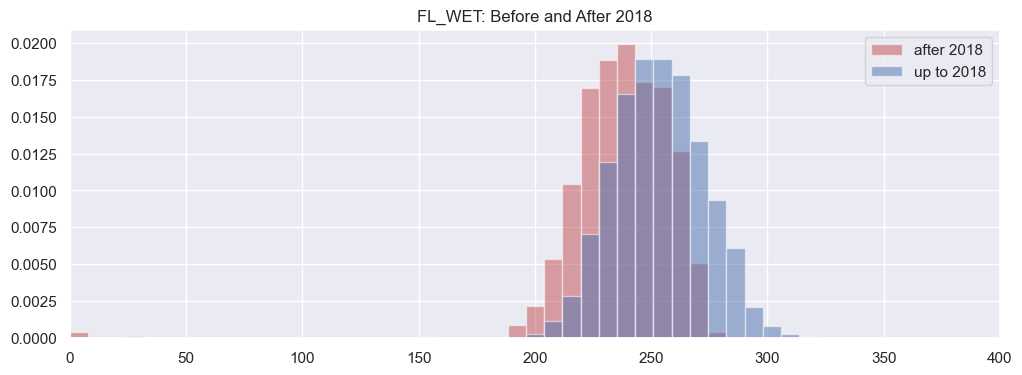

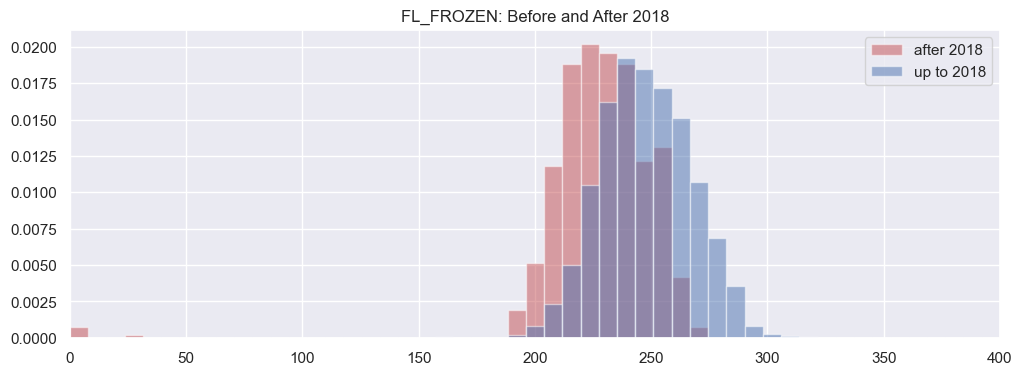

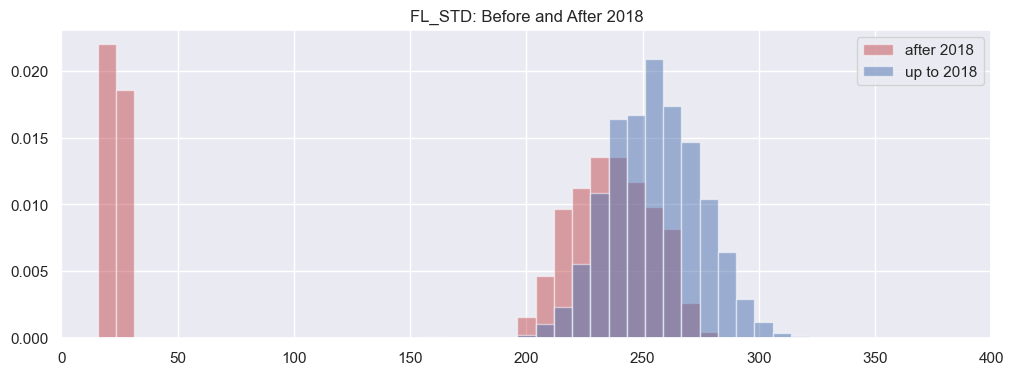

In [15]:
def hist_compare_years(year, feature, bins=50, xmin=0, xmax=400):
    
    plt.figure(figsize=(12,4))
    plt.xlim(xmin, xmax)
    
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    
    df_FD.loc[df_FD.DATETIME.dt.year > year, feature].hist(alpha=0.5, color=sns.color_palette()[3], density=True, label=f'after {year}', bins=bins_plot)
    df_FD.loc[df_FD.DATETIME.dt.year <= year, feature].hist(alpha=0.5, density=True, label=f'up to {year}', bins=bins_plot)
    
    plt.legend(loc='upper right')
    
    plt.title(feature.upper() + ': Before and After ' + str(year))
    plt.show()
    

# compare years and features
features_to_compare = ['FL_WET', 'FL_FROZEN', 'FL_STD']
years_to_compare = [2018]

for feature in features_to_compare:
    for year in years_to_compare:
        hist_compare_years(year, feature)

### FL_STD: null or scale - CONFIRM

In [16]:
sum(df_FD.FL_STD < 100)

264


outlier min date: 2019-05-31 00:00:00
outlier max date: 2019-06-21 00:00:00


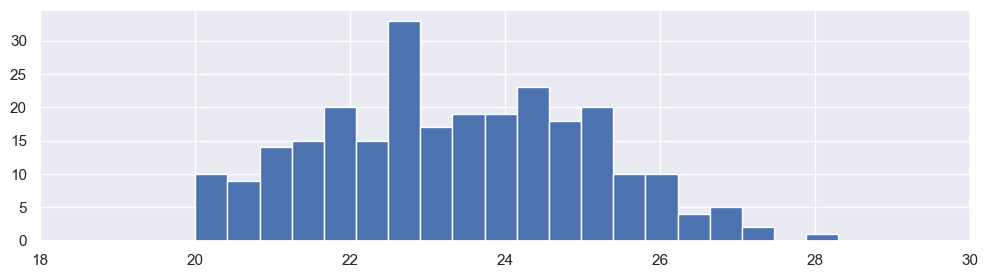

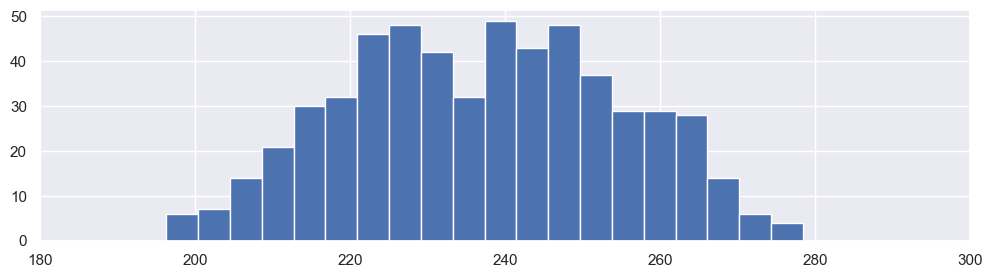

In [17]:
# looks like it's off by a multiple
print()
print('outlier min date:', df_FD[df_FD.FL_STD < 100].DATETIME.min())
print('outlier max date:', df_FD[df_FD.FL_STD < 100].DATETIME.max())

df_FD[df_FD.FL_STD < 100].FL_STD.hist(figsize=(12,3), bins=20)
plt.xlim(18, 30)
plt.show()

# histogram of same year, excluding outliers
df_FD[(df_FD.YEAR == 2019) & (df_FD.FL_STD > 100)].FL_STD.hist(figsize=(12,3), bins=20)
plt.xlim(180, 300)
plt.show()

In [18]:
confirm_FL_STD_null = True  # set to null
confirm_FL_STD_scale = False

# record indices of problems before transforming
index_FL_STD_problems = list(df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'].index)

if confirm_FL_STD_null:
    df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = np.nan
if confirm_FL_STD_scale:
    df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] * 10

### FL_WET and FL_FROZEN: null or scale - CONFIRM

In [19]:
# these also look like they are off by multiples

print('median FL_WET: ', df_FD.FL_WET.median())
print('median FL_FROZEN: ', df_FD.FL_FROZEN.median())

display(df_FD[(df_FD.FL_WET < 100) | (df_FD.FL_FROZEN < 100)][['FL_WET', 'FL_FROZEN']])

median FL_WET:  251.0
median FL_FROZEN:  247.0


,FL_WET,FL_FROZEN
35048,2,3
35161,28,28
35241,2,2
35246,1,1
35247,2,3


In [20]:
confirm_FL_WF_null = True  # set to null
confirm_FL_WF_scale = False

idx_dict = {
    35048: 100,
    35161: 10,
    35241: 100,
    35246: 100,
    35247: 100
}

# split these into variables to improve readability
indices = idx_dict.keys()
scale_factors = [idx_dict[k] for k in idx_dict.keys()]

if confirm_FL_WF_null:
    df_FD.loc[indices, 'FL_WET'] = np.nan
    df_FD.loc[indices, 'FL_FROZEN'] = np.nan
if confirm_FL_WF_scale:
    df_FD.loc[indices, 'FL_WET'] = df_FD.loc[indices, 'FL_WET'] * scale_factors
    df_FD.loc[indices, 'FL_FROZEN'] = df_FD.loc[indices, 'FL_FROZEN'] * scale_factors

In [21]:
# check results
df_FD.loc[indices, ['FL_WET', 'FL_FROZEN']]

,FL_WET,FL_FROZEN
35048,<NA>,<NA>
35161,<NA>,<NA>
35241,<NA>,<NA>
35246,<NA>,<NA>
35247,<NA>,<NA>


### how many FL_WET or FROZEN but not FL_STD exist?

In [22]:
TEMP = df_FD[df_FD.FL_STD.isnull() & (df_FD.FL_WET.notna() | df_FD.FL_FROZEN.notna())][['DATETIME', 'FL_WET', 'FL_FROZEN', 'FL_STD']]
print(TEMP.shape[0], 'entries\n')
print(rand_samp := 10, 'random samples:')
display(TEMP.sample(rand_samp))

1457 entries

10 random samples:


,DATETIME,FL_WET,FL_FROZEN,FL_STD
36665,2021-06-17,230,<NA>,NaN
35952,2021-05-25,251,<NA>,NaN
36806,2021-06-25,246,<NA>,NaN
35837,2021-05-20,276,<NA>,NaN
36543,2021-06-15,251,<NA>,NaN
32414,2016-06-09,<NA>,245,NaN
35868,2021-05-20,236,<NA>,NaN
36464,2021-06-15,246,<NA>,NaN
35693,2019-06-19,<NA>,222,NaN
36241,2021-06-03,229,<NA>,NaN


In [23]:
# what is the ratio, FROZEN to STD
TEMP = df_FD[df_FD.FL_STD.notna() & df_FD.FL_FROZEN.notna()]
(TEMP.FL_STD / TEMP.FL_FROZEN).describe()

count   25326.000
mean        1.033
std         0.002
min         1.026
25%         1.031
50%         1.032
75%         1.034
max         1.054
dtype: float64

### impute FL_STD from FL_FROZEN * factor - CONFIRM
##### NOTE: right now only one length is imported into dm_apps = FL_STD - CONFIRM

In [24]:
# how many missing values
(
    sum(df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna()),                             # only frozen FL data
    sum(df_FD.FL_STD.isnull() & df_FD.FL_WET.notna()),                                # only wet FL data
    sum(df_FD.FL_STD.isnull() & (df_FD.FL_FROZEN.notna() | df_FD.FL_WET.notna()))     # either wet or frozen data, but not std FL data
)
# frozen, wet, both

(264, 1193, 1457)

In [25]:
impute_fl = True
factor = 1.033  # confirm

if impute_fl:
    df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna(), 'FL_STD'] = 1.033 * df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna(), 'FL_FROZEN']
    df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_WET.notna(), 'FL_STD'] = df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_WET.notna(), 'FL_WET']
    
    # convert back to int after float math
    df_FD['FL_STD'] = df_FD['FL_STD'] // 1
    df_FD['FL_STD'] = df_FD['FL_STD'].astype('Int64')

In [26]:
# after
(
    sum(df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna()),                             # only frozen FL data
    sum(df_FD.FL_STD.isnull() & df_FD.FL_WET.notna()),                                # only wet FL data
    sum(df_FD.FL_STD.isnull() & (df_FD.FL_FROZEN.notna() | df_FD.FL_WET.notna()))     # either wet or frozen data, but not std FL data
)
# frozen, wet, both

(0, 0, 0)

### WEIGHT: Nullify outliers - CONFIRM
* they all look real except 1934g fish which could be checked manually

In [27]:
max_weight = 500

df_FD.loc[df_FD.WEIGHT > max_weight]

,DATETIME,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,SITE_notes,SITE1,SITE2,SITE3
718,1984-05-01,1984,5,1,<NA>,12,NaN,Frozen,30,<NA>,316,325,519.000,A,F,2,NaN,NaN,7,6,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,7,6,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>
914,1984-05-02,1984,5,2,<NA>,12,NaN,Frozen,1,<NA>,316,325,539.000,A,F,2,NaN,NaN,8,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,8,4,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>
1348,1984-05-08,1984,5,8,<NA>,12,NaN,Frozen,27,<NA>,310,319,501.000,A,F,2,NaN,NaN,8,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,8,3,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>
1800,1985-05-16,1985,5,16,<NA>,12,NaN,Frozen,5,<NA>,317,326,512.000,A,F,2,83.000,NaN,9,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,9,3,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>
5324,1989-05-13,1989,5,13,<NA>,35,PM,Frozen,23,<NA>,305,314,503.000,A,F,4,95.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,35,35,<NA>,<NA>
34988,2019-06-11,2019,6,11,7,41,PM,Frozen,1,<NA>,<NA>,<NA>,1934.000,A,M,4,NaN,JM,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>


In [28]:
confirm_WEIGHT_null = False 

if confirm_WEIGHT_null:
     df_FD.loc[df_FD.WEIGHT > max_weight, 'WEIGHT'] = np.nan
        
# DEAL WITH 1934g FISH MANUALLY
df_FD.loc[df_FD.WEIGHT > 1900, 'WEIGHT'] = np.nan

In [29]:
# no other weights to nullify - CONFIRM







### GONAD_WEIGHT: Nullify outliers - CONFIRM

In [30]:
max_gonad_weight = 200

df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight]

,DATETIME,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,SITE_notes,SITE1,SITE2,SITE3
5590,1989-05-16,1989,5,16,<NA>,38,PM,Frozen,41,<NA>,270,278,283.000,A,F,4,417.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,38,38,<NA>,<NA>
14050,1995-06-02,1995,6,2,5,41,AM,Frozen,7,<NA>,276,284,337.000,A,F,4,766.000,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"41,35",41,35,<NA>
23051,2008-05-20,2008,5,20,4,26,AM,Frozen,14,<NA>,260,268,277.300,A,F,4,414.800,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,NaN,NaN,NaN,NaN,26,26,<NA>,<NA>
23498,2008-06-04,2008,6,4,6,5,AM,Fresh,24,240,<NA>,240,176.400,A,F,4,219.600,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,NaN,NaN,NaN,NaN,5,5,<NA>,<NA>
25251,2010-05-05,2010,5,5,2,41,PM,Frozen,30,<NA>,262,270,233.700,A,F,4,335.500,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>
26652,2011-06-04,2011,6,4,5,41,AM,Fresh,32,255,<NA>,255,220.300,A,F,4,280.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>
32829,2017-06-14,2017,6,14,7,25,AM,Frozen,14,<NA>,246,254,183.400,B,F,4,256.000,JM,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,5,3,NaN,NaN,NaN,NaN,25,25,<NA>,<NA>


In [31]:
confirm_GONAD_null = True  # all of these have gonads that weight more than the total weight

if confirm_GONAD_null:
     df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight, 'GONAD_WEIGHT'] = np.nan

### Validate weight to length ratio - CONFIRM

##### need to flag these and manually deal with them individually 


[4:25 PM] Fishman, David
would be based on length in cm and weight in g

<img style="float: left;" src=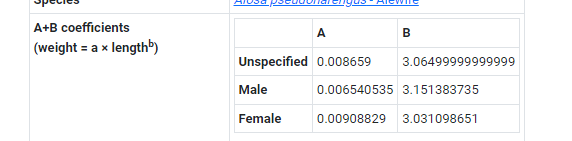>

In [32]:
def lw_prediction_delta(sex, length_mm, weight_g):
    """
    returns actual weight / predicted weight, based on length and sex
    """
    
    sex, length_mm, weight_g = str(sex), float(length_mm), float(weight_g)
    
    if sex.lower()[0] == 'm':
        A, B = 0.00654, 3.15
    elif sex.lower()[0] == 'f':
        A, B = 0.00909, 3.03
    else:
        A, B = 0.00866, 3.06
        
    # in grams, length converted mm to cm
    predicted_weight_g = A * ((length_mm / 10) ** B)
    
    return weight_g / predicted_weight_g


In [33]:
# check the length width ratio outliers
df_FD['lw_ratio_check'] = 0.0

for i, row in df_FD.iterrows():
    try:
        df_FD.loc[i, 'lw_ratio_check'] = lw_prediction_delta(row['SEX'], row['FL_STD'], row['WEIGHT'])
    except TypeError:
        df_FD.loc[i, 'lw_ratio_check'] = np.nan
        
# number of samples with extraordinary dimensions
avg_ratio = df_FD['lw_ratio_check'].describe()['mean']
stdev = df_FD['lw_ratio_check'].describe()['std']

# how many standard deviations out should we examine?
n_stdev = 4
# with 3 stdev, there are 120 outliers to check (following FL cleaning above)

lw_ratio_min, lw_ratio_max = avg_ratio - n_stdev*stdev, avg_ratio + n_stdev*stdev
df_FD[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max)].shape

(37, 41)

In [34]:
# these are our outliers
columns = ['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 'GONAD_WEIGHT', 'lw_ratio_check']
df_FD[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max)].sort_values('lw_ratio_check')[columns]

,CONDITION,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,lw_ratio_check
25655,Frozen,<NA>,283,292,33.300,A,F,4,61.600,0.133
21595,Frozen,<NA>,205,212,15.100,B,M,4,NaN,0.153
22681,Frozen,<NA>,366,376,170.900,A,F,4,23.500,0.317
32006,Fresh,358,<NA>,358,178.800,A,F,4,20.200,0.385
25903,Frozen,<NA>,299,308,150.900,A,M,4,NaN,0.472
26230,Fresh,299,<NA>,299,146.100,A,M,4,NaN,0.502
27534,Frozen,<NA>,244,252,93.700,B,M,4,NaN,0.552
30189,Frozen,<NA>,241,249,103.600,B,M,3,NaN,0.634
35838,Fresh,217,<NA>,217,196.900,A,M,4,NaN,1.857
208,Fresh,257,<NA>,257,337.000,A,M,2,NaN,1.865


### CONFIRM: whether any rows should be nulled/dropped/fixed

In [35]:
# TODO: as needed, drop / impute / convert









In [36]:
# drop the lw_ratio_check before saving
df_FD = df_FD.drop('lw_ratio_check', axis=1)

### Create a combined 'remarks' column

In [37]:
# IDEA: add PERIOD to remarks? - CONFIRM

FD_comments = [
    'SITE_notes', 
    'Ager_1', 'Ager_2', 'Ager_3', 
    'Comments_1', 'Comments_2', 'Comments_3', 'Envelop.Comments', 
    'AGE_notes_1', 'FSP_notes_1', 'AGE_notes_2', 'FSP_notes_2', 'AGE_notes_3', 'FSP_notes_3'
]

# # this complicated double lambda is a combination of these 3 concepts
# # there is likely a cleaner way to do this, so I left my logic here for posterity
# df_FD[FD_comments].apply(lambda x: '; '.join(x.dropna().astype(str)), axis=1)
# df_FD[FD_comments].apply(lambda x: x.name, axis=0).astype(str)
# df_FD[FD_comments].apply(lambda x: (x.dropna().name + ': ' + x.dropna().astype(str)), axis=0)

df_FD['remarks'] = df_FD[FD_comments].apply(lambda x: (x.dropna().name + ': ' + x.dropna().astype(str)), axis=0).apply(lambda x: '; '.join(x.dropna().astype(str)), axis=1)

In [38]:
# check a sample of the remarks
df_FD.sample(10)[['DATETIME', 'remarks']]

,DATETIME,remarks
837,1984-05-15,SITE_notes: 12; AGE_notes_1: 3; FSP_notes_1: 3
33596,2018-05-23,SITE_notes: 62; Ager_1: JM; Ager_3: Jmac; Comments_1: V NICE; AGE_notes_1: 4; AGE_notes_3: 4; FSP_notes_3: 4
9250,1990-06-06,SITE_notes: 56; AGE_notes_1: 4; FSP_notes_1: 4
692,1984-04-30,SITE_notes: 12; AGE_notes_1: 4; FSP_notes_1: 4
2177,1985-06-18,SITE_notes: 12; AGE_notes_1: 4; FSP_notes_1: 3
18049,2000-05-05,SITE_notes: 38; AGE_notes_1: 5; FSP_notes_1: 4
33450,2018-05-15,SITE_notes: 33; Ager_1: JM; Ager_3: Jmac; Comments_1: NICER; AGE_notes_1: 4; AGE_notes_3: 4; FSP_notes_3: 4
35747,2021-05-18,"SITE_notes: 62; Ager_2: LF; Comments_2: Possible 6-4, uncertain on maiden spawning; AGE_notes_2: 7; FSP_notes_2: 5"
3017,1986-05-29,SITE_notes: 12; AGE_notes_1: 3; FSP_notes_1: 3
10324,1993-05-15,SITE_notes: 49; AGE_notes_1: 4; FSP_notes_1: 4


# LENGTH FREQUENCIES

In [39]:
df_LF = pd.read_csv(r'.\provided data\Margaree Gaspereau lgth-freq_Master.csv')

### Clean Date/Time and create DATETIME column

In [40]:
# convert all times to same format, set missing times to 0000 (date only), then to datetime format
df_LF['CleanTime'] = df_LF['Time']
df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] = df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] * 100
df_LF['CleanTime'] = pd.to_datetime(df_LF.CleanTime, format='%H%M')

# all null times should be 0000 (which pandas reads as no time data)
df_LF.loc[df_LF['CleanTime'].isnull(), 'CleanTime'] = pd.to_datetime(0)  

df_LF['DATETIME'] = pd.to_datetime(dict(
    year=df_LF['yy'], 
    month=df_LF['mm'], 
    day=df_LF['dd'], 
    hour=df_LF['CleanTime'].dt.hour, 
    minute=df_LF['CleanTime'].dt.minute
), errors='coerce')

df_LF = df_LF.drop('CleanTime', axis=1)

### Clean River Column

In [41]:
df_LF.loc[df_LF.river == 'SW Margaree', 'river'] = 'SW MARGAREE'
df_LF.river.unique()

array([nan, 'MARGAREE', 'SW MARGAREE'], dtype=object)

### Expand and Clean Site Column
* Later analysis shows matching with samples on the first noted site is more effective than combining multiple sites. 
* Consider adding extra sites to notes column or adding the ability to select multiple sites when inputting a sample.

In [42]:
df_LF[['SITE1', 'SITE2', 'SITE3']] = df_LF.site.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

### Clean Location

In [43]:
# clean the typos
df_LF.loc[df_LF['loc'] == 'LOWER ', 'loc'] = 'LOWER'
df_LF.loc[df_LF['loc'] == 'LOWE', 'loc'] = 'LOWER'
df_LF['loc'].unique()

array(['LOWER', 'UPPER', nan], dtype=object)

### Period: AD left as is - CONFIRM

In [44]:
df_LF.period.unique()

array(['PM', 'AM', 'AD'], dtype=object)

In [45]:
# counts: AM, PM, and AD
# AD data are also included in the FISH DETAILS, assumed not a typo (although rare)
sum(df_LF.period == 'AM'), sum(df_LF.period == 'PM'), sum(df_LF.period == 'AD')

(6143, 5250, 47)

# SAMPLES (logbook)

In [46]:
dtypes = {
    'code': 'object',
    'no_nets': 'object',
    'YEAR': 'Int32',
    'MM': 'Int32',
    'DD': 'Int32',
    'Week': 'Int32',
#     'hours_fished': 'Int32'  # some entries say 'maximum '
}
df_SD = pd.read_csv(r'.\provided data\Margaree Gaspereau logbooks_Master.csv', dtype=dtypes)

### replace hours_fished = 'maximum' with a number of hours - CONFIRM

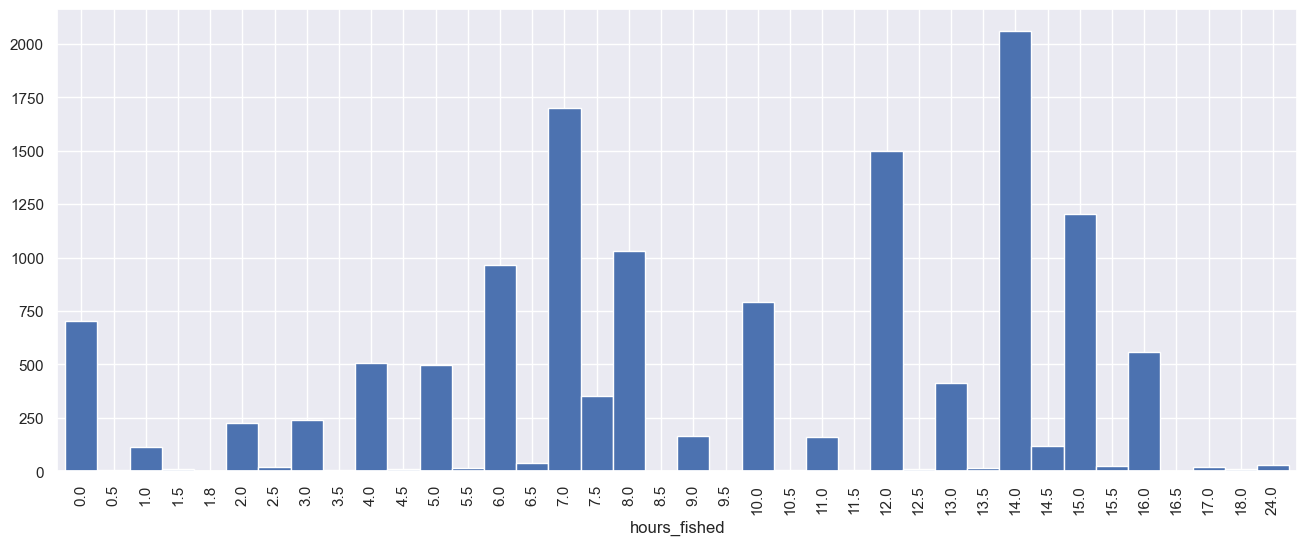

In [47]:
(
    df_SD.groupby('hours_fished')
    .count()
    .reset_index()
    .replace({'maximum ': 24})[['hours_fished', 'DIST']]
    .astype(float)
    .sort_values('hours_fished')
    .plot(kind='bar', x='hours_fished', y='DIST', width=1, figsize=(16, 6), legend=False)
);

In [48]:
# CONFIRM 24 is the correct time
# will import better if it is numeric formatting
numeric_hours_fished = True

if numeric_hours_fished:
    df_SD.loc[df_SD.hours_fished == 'maximum ', 'hours_fished'] = 24  # max could be 18
    df_SD['hours_fished'] = pd.to_numeric(df_SD['hours_fished'], errors='coerce').astype(float)

### NAME column
Create Samplers Table / Clean Sampler Names - CONFIRM

In [49]:
# SHOULD ANY OF THESE BE SUBSTITUTED / SPELLING CORRECTED?

sorted([str(x) for x in df_SD.NAME.unique()])

['Alexander Gillis',
 'Alexander MacDonald',
 'Allan B Gillis',
 'Anthony Cameron',
 'Brian Doyle',
 'Brian MacFarlane',
 'Bruce MacLellan',
 'Bruce McLellan',
 'Catherine MacFarlane',
 'Catherine MacLeod',
 'Charles McDaniel',
 'Chris MacLean',
 'Colin Gillis',
 'Daniel Stewart',
 'Darlene Cameron',
 'David MacKinnon',
 'Donald D Gillis',
 'Donald J Gillis',
 'Donald M Campbell',
 'Donald MacEachern',
 'Donald MacLeod',
 'Donald Macleod',
 'Donelda M Gillis',
 'Eleanor MacLellan',
 'Eleanor McDaniel',
 'Elizabeth MacKinnon',
 'Elizabeth/Vincent MacKinnon',
 'Finley MacDonald',
 'Finley Stewart',
 'Florence Gillis',
 'Fred Ingram',
 'Gerard MacFarlane',
 'Gerard V Chiasson',
 'Harold MacFarlane',
 'Hugh J Gillis',
 'Hughie MacDonnell',
 'Irene MacIsaac',
 'Jack MacLellan',
 'James A Hirtle',
 'James MacFarlane',
 'Jim Coady',
 'Jim MacFarlane',
 'Joan Ingram',
 'John A Chisholm',
 'John A Coady',
 'John Coady',
 'John H Gillis',
 'John MacLellan',
 'John Neil Gillis',
 'John R Gillis',

In [50]:
# Clean NAME column manually - CONFIRM
sampler_replacements = {
#     'Bruce MacLellan': 'Bruce McLellan',                     # CONFIRM
#     'Elizabeth/Vincent MacKinnon': 'Elizabeth MacKinnon',    # CONFIRM
    'Kevin MacKinnon ': 'Kevin MacKinnon',
    'Donald Macleod': 'Donald MacLeod'
}

# clean the name column
df_SD = df_SD.replace({'NAME': sampler_replacements})

In [51]:
# create samplers table

gaspereau_samplers = list()

for i in sorted(str(x) for x in df_SD.NAME.unique()):
    name = i.rsplit(maxsplit=1)  # put initials into first name
    gaspereau_samplers.append(name)
    
gaspereau_samplers = pd.DataFrame(gaspereau_samplers, columns=['first_name', 'last_name'])
gaspereau_samplers['notes'] = pd.NA  # all null comments

### Sites

In [52]:
# create columns for multiple sites
df_SD[['SITE1', 'SITE2']] = df_SD.SITE_NO.str.split(',', expand=True).fillna(pd.NA)

### DATETIME
* confirm leave null when missing days/months

In [53]:
df_SD['DATETIME'] = pd.to_datetime(
    df_SD['YEAR'].astype(str) + '-' + df_SD['MM'].astype(str) + '-' + df_SD['DD'].astype(str), 
    errors='coerce'  # coerce missing days and months into errors
)
# NOTE: these coerced errors do not affect the lookup ID for importing:
    # any entries with missing month or day will have NA filled with 0
    # ID is generated from YEAR, MM, and DD columns
sum(df_SD.DATETIME.isnull())

31

### clean zone

In [54]:
df_SD.loc[df_SD.zone == 'upper ', 'zone'] = 'upper'
df_SD.zone.unique()

array(['lower', 'upper', nan], dtype=object)

### clean bycatch / pre-generate 'remarks' before import - CONFIRM
* could also pregenerate notes/comments/remarks
    * add 'sbass' after int, concat if exists, etc
    * add extra sites to remarks?
    

### Note: Code for kwargs lookup in the import script used to combine remarks - it is cleaner in this notebook

        # remarks
        remarks = str()
        check_for_comments = ['COMMENTS', 'BYCATCH_SBASS', 'BYCATCH_SHAD', 'BYCATCH_OTHER']
        for column in check_for_comments:
            if row[column] and not row[column].isnumeric():  # if the row is non-blank, and not a string of a number
                remarks += (remarks != str()) * '; ' + row[column]  # add a semicolon between separate non-null comments
        kwargs['remarks'] = remarks

In [55]:
df_SD.bycatch_sbass.unique()

array([nan,  3.,  1.,  2.])

In [56]:
df_SD.bycatch_shad.unique()

array([nan,  1.])

In [57]:
df_SD.bycatch_other.unique()

array([nan, 'salmon', '1 perch, 1 speckled trou, 1 30 inch salmon',
       '1 lamprey eel (?)', '1', '2 trout', '1 trout', '5 lampreys',
       '1 baby lamprey', '4 trout, 3 "lamprey eels" (?)', '1 perch',
       '4 suckers', 'lamprey', '1 sucker'], dtype=object)

In [58]:
df_SD.comments.unique()

array([nan, 'striped bass were 23 inches',
       'river still high, fishing inside wing',
       'catch a salmon no marking 14 inch long', 'salted 4800 lbs',
       'salted 5000 lbs', 'outside wing in, river high',
       'salted 8000 lbs', '5 gaspereau', '26 gaspereau', 'did not fish',
       'Rainbow trout released', 'salmon', 'trout', 'salt', 'bait',
       'did not fish, returned logbook', 'wet snow', '6 fish',
       'heavy rain, flood', '3 fish', '10 fish', '1 fish', '8 fish',
       'heavy rain', 'did not fish on the 22nd. Water too high.'],
      dtype=object)

In [59]:
check_for_comments = ['comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other']

# update bycatch fields to text fields
df_SD.loc[df_SD['bycatch_sbass'].notna(), 'comment_sbass'] = 'bycatch_sbass: ' + df_SD[df_SD['bycatch_sbass'].notna()]['bycatch_sbass'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_shad'].notna(), 'comment_shad'] = 'bycatch_shad: ' + df_SD[df_SD['bycatch_shad'].notna()]['bycatch_shad'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_other'].notna(), 'comment_other'] = 'bycatch_other: ' + df_SD[df_SD['bycatch_other'].notna()]['bycatch_other']

# combine with semicolon to make remarks field
df_SD['remarks'] = df_SD[['comments', 'comment_sbass', 'comment_shad', 'comment_other']].apply(lambda x: '; '.join(x.dropna()), axis=1)

# set empty strings to NaN
df_SD.loc[df_SD.remarks == '', 'remarks'] = np.nan  

# drop extra bycatch string columns
df_SD = df_SD.drop(['comment_sbass', 'comment_shad', 'comment_other'], axis=1)

In [60]:
# check results
df_SD[df_SD.remarks.notna()].sample(5)

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,remarks
15009,2,SWMARG,Bruce MacLellan,NaN,81,51,1,2019,5,18,3,1.000,0.500,6.000,upper,MacLellan,3 fish,NaN,NaN,NaN,51,<NA>,2019-05-18,3 fish
14392,2,SWMARG,Stewart Gillis,NaN,81,41,1,2017,5,16,3,60.000,27.200,7.000,upper,Gillis,"river still high, fishing inside wing",NaN,NaN,NaN,41,<NA>,2017-05-16,"river still high, fishing inside wing"
15098,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2019,6,20,8,7400.000,3356.600,15.500,lower,Chiasson,NaN,1.000,1.000,"4 trout, 3 ""lamprey eels"" (?)",26,<NA>,2019-06-20,"bycatch_sbass: 1; bycatch_shad: 1; bycatch_other: 4 trout, 3 ""lamprey eels"" (?)"
14626,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2018,5,10,2,200.000,90.700,7.000,lower,Chiasson,Rainbow trout released,NaN,NaN,1,26,<NA>,2018-05-10,Rainbow trout released; bycatch_other: 1
14586,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2017,6,22,8,2700.000,1224.700,7.000,lower,Chiasson,NaN,3.000,NaN,NaN,26,<NA>,2017-06-22,bycatch_sbass: 3


# ======================
# FORMATING FOR IMPORT
# ======================

* ALLCAPS: denotes columns that aren't perfect matches
* lowercase: denotes columns that should match perfectly with herring tables in dm_apps

# LENGTH FREQUENCIES
### Generate Unique IDs to Import / match with Samples

In [61]:
# replace non-numeric data with made up site numbers
# NOTE: These are converted back in import script
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
df_LF = df_LF.replace({'SITE1': id_replacements})

In [62]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [63]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [64]:
if df_LF.id.max() < 2_100_000_000: # only run this once

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

### Length Bins

In [65]:
# use the same bins as used in the herring database (cm, grouped by 0.5s)
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

### LENGTH FREQUENCY 
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [66]:
gaspereau_lengthfrequency = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1)

# FISH DETAILS

In [67]:
df_FD['sample_id'] = (
    df_FD.YEAR.astype(int)*1_000_000 
    + df_FD.MM.fillna(0).astype(int)*10_000
    + df_FD.DD.fillna(0).astype(int)*100
    + df_FD.SITE.fillna(0).astype(int)
).astype('Int64')

### FISH DETAILS
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [68]:
# ALL CAPS used for unmatched fields, lowercase match id from dm_apps
rename_FD = {
    'FISH_NO': 'fish_number', 'FL_STD': 'fish_length', 'WEIGHT': 'fish_weight', 'MATURITY': 'maturity_id', 'GONAD_WEIGHT': 'gonad_weight',
    'Envelop.Comments': 'ENVELOP_COMMENTS',
    'Ager_1': 'AGER_1', 'Comments_1': 'COMMENTS_1', 
    'Ager_2': 'AGER_2', 'Comments_2': 'COMMENTS_2', 
    'Ager_3': 'AGER_3', 'Comments_3': 'COMMENTS_3', 
}

gaspereau_fishdetails = df_FD[[
    'sample_id', 'DATETIME', 'SITE', 'PERIOD', 'CONDITION', 'FISH_NO', 
    'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 'GONAD_WEIGHT', 
    'Ager_1', 'AGE_1', 'FSP_1', 'Comments_1', 
    'Ager_2', 'AGE_2', 'FSP_2', 'Comments_2', 
    'Ager_3', 'AGE_3', 'FSP_3', 'Comments_3', 
    'Envelop.Comments', 'remarks'
]].rename(columns=rename_FD)

# SAMPLES

In [69]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [70]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

### Add null* Sample Data for unmatched length frequencies and fish details - CONFIRM
### * (date, site, all else null)
* if these null data are added, all fish detail and length frequencies should get into dm_apps
* if null data are not added, unmatched fish detail and length frequencies will be added to rejected files (csv generated on import)

In [71]:
# how many length frequency measurements are matched with samples?
# apprx 80%
(
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique(), 
    df_LF.id.nunique(), 
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique() / df_LF.id.nunique()
)

(731, 917, 0.797164667393675)

In [72]:
# how many fish detail sample ids are matched with samples id column?
# apprx 81% (95% after correcting for LF missing - significant overlap)
(
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique(), 
    df_FD.sample_id.nunique(), 
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique() / df_FD.sample_id.nunique()
)

(925, 1145, 0.8078602620087336)

In [73]:
add_null_data_where_unmatched = False  # CONFIRM

if add_null_data_where_unmatched:
    # add null samples where no match exists - Length Frequencies
    df_SD = pd.concat([
        df_SD, 
        df_LF[~df_LF.id.isin(set(df_SD.id))].drop_duplicates('id')[['id', 'DATETIME', 'SITE1']]
    ]).reset_index(drop=True)
    
    # add null samples where no match exists - Fish Details
    df_SD = pd.concat([
        df_SD, 
        df_FD[~df_FD.sample_id.isin(set(df_SD.id))].rename({'sample_id':'id'},axis=1).drop_duplicates('id')[['id', 'DATETIME', 'SITE1']]
    ]).reset_index(drop=True)

### SAMPLE DATA
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [74]:
# ALL CAPS FOR UNMATCHED
rename_SD = {
    'id': 'sample_id',  # rename id to be sample_id to be consistent with fish detail and length frequencies
    'DATETIME': 'sample_date', 'DIST': 'district_id', 
    'NAME': 'SAMPLER', 'code': 'CODE', 'GEAR': 'gear_id', 'SITE1': 'SITE',
    'no_nets': 'NO_NETS', 'catch_lbs': 'catch_weight_lbs', 'hours_fished': 'HOURS_FISHED', 
    'zone': 'ZONE', 'last_name': 'LAST_NAME', 'comments': 'COMMENTS',
    'bycatch_sbass': 'BYCATCH_SBASS', 'bycatch_shad': 'BYCATCH_SHAD', 'bycatch_other': 'BYCATCH_OTHER', 
    'wt_lbs': 'sample_weight_lbs'
}

# JOIN with Length Frequency table to get sample weight
gaspereau_sample = pd.merge(
    df_SD[[
        'id', 'DATETIME', 'DIST', 'RIVER', 'NAME', 'code', 'GEAR', 'SITE1', 'no_nets', 'catch_lbs', 'hours_fished', 
        'zone', 'last_name', 'comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other', 'remarks'
    ]], 
    df_LF[['id', 'wt_lbs']],
    on='id', 
    how='left'  # all samples 
).drop_duplicates().reset_index(drop=True).rename(columns=rename_SD)

# change SITE to int filetype for data visualisation, error checking, etc
# gaspereau_sample['SITE'] = gaspereau_sample['SITE'].astype('Int64')  # I have no idea why this doesn't work
gaspereau_sample['SITE'] = gaspereau_sample['SITE'].fillna(0).astype(np.int64).replace({0: np.nan}).astype('Int64')  # I have no idea why this does work

# SAVE TABLES

In [75]:
# save pickle files
if True:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_pickle('gaspereau_lengthfrequency.pickle')
    gaspereau_fishdetails.to_pickle('gaspereau_fishdetails.pickle')
    gaspereau_sample.to_pickle('gaspereau_sample.pickle')
    gaspereau_samplers.to_pickle('gaspereau_samplers.pickle')
    
# save csv for import into django
if True:  # change this to overwrite/resave
    import_file_location = 'C:\\Users\\CARRK\\Documents\\Repositories\\dm_app_root\\dm_apps\\herring\\temp\\'
    
    gaspereau_lengthfrequency.to_csv(import_file_location + 'gaspereau_lengthfrequency.csv')
    gaspereau_fishdetails.to_csv(import_file_location + 'gaspereau_fishdetails.csv')
    gaspereau_sample.to_csv(import_file_location + 'gaspereau_sample.csv')
    gaspereau_samplers.to_csv(import_file_location + 'gaspereau_samplers.csv')